# Project 5
## Team 6: Maya Flores, Selina Spry, Emma Williams

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from commpy.filters import rcosfilter, rrcosfilter
import scipy.interpolate
import math
import scipy.signal

In [6]:
# Define plotting parameters
pxoffset = 1
pyoffset = 1
pwidth = 7
pheight = 4
smalltxtsize = 12
medtxtsize = 14
bigtxtsize = 18

plt.rc('font', size=smalltxtsize)          # controls default text sizes
plt.rc('axes', titlesize=smalltxtsize)     # fontsize of the axes title
plt.rc('axes', labelsize=medtxtsize)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=smalltxtsize)    # fontsize of the tick labels
plt.rc('ytick', labelsize=smalltxtsize)    # fontsize of the tick labels
plt.rc('legend', fontsize=smalltxtsize)    # legend fontsize
plt.rc('figure', titlesize=bigtxtsize)  # fontsize of the figure title

In [7]:
# Equivalent implementation of MATLAB's interp function
def interpolate_1d_vector(vector, factor):
    """
    Interpolate, i.e. upsample, a given 1D vector by a specific interpolation factor.
    :param vector: 1D data vector
    :param factor: factor for interpolation (must be integer)
    :return: interpolated 1D vector by a given factor
    """
    x = np.arange(np.size(vector))
    y = vector
    f = scipy.interpolate.interp1d(x, y, kind='cubic')

    x_extended_by_factor = np.linspace(x[0], x[-1], np.size(x) * factor)
    y_interpolated = np.zeros(np.size(x_extended_by_factor))

    i = 0
    for x in x_extended_by_factor:
        y_interpolated[i] = f(x)
        i += 1

    return y_interpolated

In [8]:
# Define simulation parameters to be used in Section 2 and Section 3
N_bits = 10000 # Total number of bits for entire transmission
f_c = 2        # Carrier frequency
f_s = 10       # Sampling frequency
f_d = 1        # Digital system sampling frequency
beta = 0.5     # Roll-off factor for raised cosine filter
sigma_n = 0.25 # Noise standard deviation

In [9]:
# Generate random binary data stream
bin_data = np.around(np.random.random((N_bits,)))

# Assignment of binary sets to amplitude values
bin1 = bin_data # Binary data stream for 2-ASK
bin2 = bin_data.reshape((2,int(N_bits/2))) # Binary data stream for 4-ASK
ampl1 = np.zeros((N_bits,))
ampl2 = np.zeros((int(N_bits/2),))

# Define amplitude mapping for 2-ASK
ampl1[bin1 == 1] = 1
ampl1[bin1 == 0] = -1

# Define amplitude mapping for 4-ASK
ampl2[(bin2[0,:] == 0) & (bin2[1,:] == 0) ] = -3
ampl2[(bin2[0,:] == 1) & (bin2[1,:] == 0) ]  = -1
ampl2[(bin2[0,:] == 0) & (bin2[1,:] == 1) ] = 1
ampl2[(bin2[0,:] == 1) & (bin2[1,:] == 1) ] = 3

In [10]:
# Apply raised cosine pulse shaping filter
ps_rcos = rcosfilter(61,0.5,1,10)[1] # Define raised cosine filter for pulse shaping

# Prepare upsampled and pulse shaped 2-ASK transmission
d_upsample = np.zeros((len(ampl1)*10,))
d_upsample[::10] = ampl1#impulse train

# Prepare upsampled and pulse shaped 4-ASK transmission
d_upsample1 = np.zeros((len(ampl2)*10,))
d_upsample1[::10] = ampl2#impulse train

# Pulse shape both 2-ASK and 4-ASK data streams
ampl1_rcos = np.convolve(ps_rcos,d_upsample,'same')
ampl2_rcos = np.convolve(ps_rcos,d_upsample1,'same')

In [11]:
# Modulate both 2-ASK and 4-ASK pulse shaped signals to carrier frequency f_c
tx_ask2_wavefm = ampl1_rcos*np.cos(2*np.pi*f_c*np.arange(0,((len(ampl1_rcos)-1)*(1/f_s)),(1/f_s)))
tx_ask4_wavefm = ampl2_rcos*np.cos(2*np.pi*f_c*np.arange(0,((len(ampl2_rcos))*(1/f_s)),(1/f_s)))

In [12]:
# Introduce Passband Additive White Gaussian Noise (AWGN) to transmission (both I and Q components)

# AWGN for passband 2-ASK signal
noise_temp = (sigma_n/math.sqrt(2))*np.random.standard_normal(len(tx_ask2_wavefm),) # 
noise2 = noise_temp*np.cos(2*np.pi*f_c*np.arange(0,((len(ampl1_rcos)-1)*(1/f_s)),(1/f_s))) + noise_temp*np.sin(2*np.pi*f_c*np.arange(0,((len(ampl1_rcos)-1)*(1/f_s)),(1/f_s)))

# AWGN for passband 4-ASK signal
noise_temp1 = (sigma_n/math.sqrt(2))*np.random.standard_normal(len(tx_ask4_wavefm),)
noise4 = noise_temp1*np.cos(2*np.pi*f_c*np.arange(0,((len(ampl2_rcos))*(1/f_s)),(1/f_s))) + noise_temp1*np.sin(2*np.pi*f_c*np.arange(0,((len(ampl2_rcos))*(1/f_s)),(1/f_s))) 

# Noise added, generating passband signals to be intercepted at receiver
rx_ask2_wavefm = tx_ask2_wavefm + noise2
rx_ask4_wavefm = tx_ask4_wavefm + noise4

In [13]:
# Demodulate 2-ASK and 4-ASK waveforms using coherent detection

# Multiple by cosine function with carrier frequency f_c to get I component
ampl1_rawi = rx_ask2_wavefm*np.cos(2*np.pi*f_c*np.arange(0,((len(ampl1_rcos)-1)*(1/f_s)),(1/f_s)))
ampl2_rawi = rx_ask4_wavefm*np.cos(2*np.pi*f_c*np.arange(0,((len(ampl2_rcos))*(1/f_s)),(1/f_s)))

# Multiple by sine function with carrier frequency f_c to get Q component
ampl1_rawq = rx_ask2_wavefm*np.sin(2*np.pi*f_c*np.arange(0,((len(ampl1_rcos)-1)*(1/f_s)),(1/f_s)))
ampl2_rawq = rx_ask4_wavefm*np.sin(2*np.pi*f_c*np.arange(0,((len(ampl2_rcos))*(1/f_s)),(1/f_s)))

# Design lowpass filter and employ it to remove double frequency terms
filt_coeffs = scipy.signal.firwin(61,0.25, window = "hamming", pass_zero = 'lowpass')
ampl1_filti = np.convolve(filt_coeffs,ampl1_rawi,'same')
ampl2_filti = np.convolve(filt_coeffs,ampl2_rawi,'same')
ampl1_filtq = np.convolve(filt_coeffs,ampl1_rawq,'same')
ampl2_filtq = np.convolve(filt_coeffs,ampl2_rawq,'same')

In [14]:
# Sample correct amplitude values from filtered I and Q components
start_samp = int(np.floor((len(rcosfilter(61,0.5,1,10)[1])) + (len(filt_coeffs)-1 )/2)) # Calculate group delay

ampl1_finali = 2*ampl1_filti[start_samp:int(start_samp + (len(ampl1)-1)*(f_s/f_d)):int(f_s/f_d)]
ampl2_finali = 2*ampl2_filti[start_samp:int(start_samp + (len(ampl2)-1)*(f_s/f_d)):int(f_s/f_d)]
ampl1_finalq = 2*ampl1_filtq[start_samp:int(start_samp + (len(ampl1)-1)*(f_s/f_d)):int(f_s/f_d)]
ampl2_finalq = 2.*ampl2_filtq[start_samp:int(start_samp + (len(ampl2)-1)*(f_s/f_d)):int(f_s/f_d)]

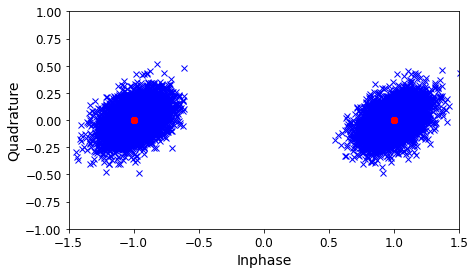

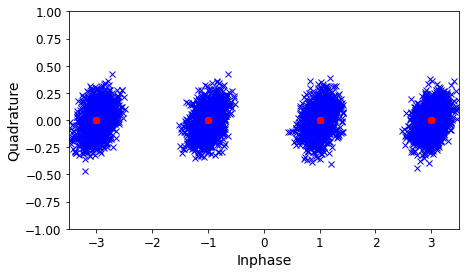

In [15]:
# Generater scatter plots of outputs
plt.figure(figsize=(pwidth,pheight))

plt.plot(ampl1_finali,ampl1_finalq,'bx',ampl1,np.zeros((len(ampl1),)),'ro')
plt.xlim([-1.5,1.5])
plt.ylim([-1,1])
plt.xlabel('Inphase')
plt.ylabel('Quadrature')
plt.savefig('scat2ask.eps', format='eps')
plt.show()

plt.figure(figsize=(pwidth,pheight))
plt.plot(ampl2_finali,ampl2_finalq,'bx',ampl2,np.zeros((len(ampl2),)),'ro')
plt.xlim([-3.5,3.5])
plt.ylim([-1,1])
plt.xlabel('Inphase')
plt.ylabel('Quadrature')
plt.savefig('scat4ask.eps', format='eps')
plt.show()

### Question 1:
<br> Plot the scatter plot of a square 4-QAM transmission prior to transmission across a channel and after sampling at the receiver. Use the sample code from Section 2
as well as the example code for this section from the Jupyter Notebook to get started.

[-1.+1.j -1.-1.j  1.-1.j ...  1.+1.j  1.-1.j -1.+1.j]


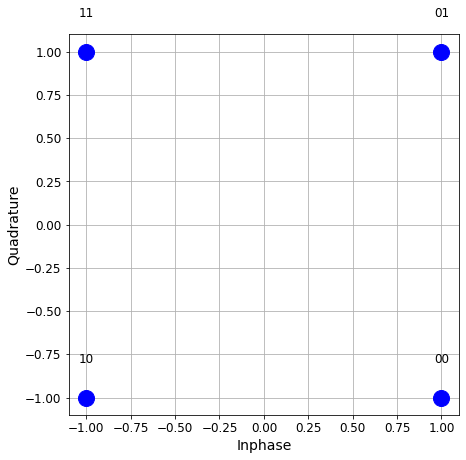

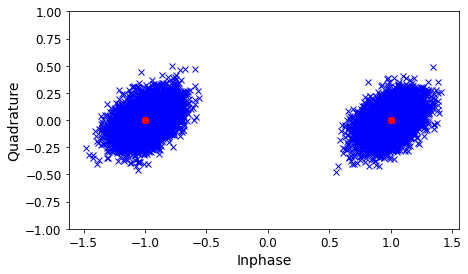

In [40]:
# bits per symbol
M = 2  

# Generate binary data stream and map it to QPSK symbols
bits = np.random.binomial(n=1, p=0.5, size=(M*N_bits, ))
def packing(bits):
    return bits.reshape((N_bits, M))
bits_packed = packing(bits)

# Define mapping between binary and I/Q domain
mapping_table = {
    (1,0) : -1-1j,
    (1,1) : -1+1j,
    (0,0) :  1-1j,
    (0,1) :  1+1j
}

def Mapping(bits):
    return np.array([mapping_table[tuple(b)] for b in bits])
QAM4 = Mapping(bits_packed)

# Apply raised cosine pulse shaping filter
ps_rcos = rcosfilter(61,0.5,1,10)[1] # Define raised cosine filter for pulse shaping

# Prepare upsampled and pulse shaped 4-QAM transmission
d_upsample1 = np.zeros((len(QAM4)*10,))
d_upsample1[::10] = QAM4#impulse train

# Pulse shape 4QAM data streams
QAM4_rcos = np.convolve(ps_rcos,d_upsample1,'same')

# Modulate 4-QAM pulse shaped signals to carrier frequency f_c
tx_QAM4_wavefm = QAM4_rcos*np.cos(2*np.pi*f_c*np.arange(0,((len(QAM4_rcos))*(1/f_s)),(1/f_s)))

# Introduce Passband Additive White Gaussian Noise (AWGN) to transmission (both I and Q components)
# AWGN for passband 4-QAM signal
noise_temp1 = (sigma_n/math.sqrt(2))*np.random.standard_normal(len(tx_QAM4_wavefm),)
noise4 = noise_temp1*np.cos(2*np.pi*f_c*np.arange(0,((len(QAM4_rcos))*(1/f_s)),(1/f_s))) + noise_temp1*np.sin(2*np.pi*f_c*np.arange(0,((len(QAM4_rcos))*(1/f_s)),(1/f_s))) 

# Noise added, generating passband signals to be intercepted at receiver
rx_QAM4_wavefm = tx_QAM4_wavefm + noise4

# Demodulate 4-QAM waveform using coherent detection
# Multiple by cosine function with carrier frequency f_c to get I component
QAM4_rawi = rx_QAM4_wavefm*np.cos(2*np.pi*f_c*np.arange(0,((len(QAM4_rcos))*(1/f_s)),(1/f_s)))

# Multiple by sine function with carrier frequency f_c to get Q component
QAM4_rawq = rx_QAM4_wavefm*np.sin(2*np.pi*f_c*np.arange(0,((len(QAM4_rcos))*(1/f_s)),(1/f_s)))

# Design lowpass filter and employ it to remove double frequency terms
filt_coeffs = scipy.signal.firwin(61,0.25, window = "hamming", pass_zero = 'lowpass')
QAM_filti = np.convolve(filt_coeffs,QAM4_rawi,'same')
QAM_filtq = np.convolve(filt_coeffs,QAM4_rawq,'same')

# Sample correct amplitude values from filtered I and Q components
start_samp = int(np.floor((len(rcosfilter(61,0.5,1,10)[1])) + (len(filt_coeffs)-1 )/2)) # Calculate group delay

QAM_finali = 2*QAM_filti[start_samp:int(start_samp + (len(QAM4)-1)*(f_s/f_d)):int(f_s/f_d)]
QAM_finalq = 2*QAM_filtq[start_samp:int(start_samp + (len(QAM4)-1)*(f_s/f_d)):int(f_s/f_d)]

# # Define corresponding demapping table
# demapping_table = {v : k for k, v in mapping_table.items()}

# Plot signal constellation
plt.figure(figsize=(pwidth,pwidth))
for b1 in [0, 1]:
    for b0 in [0, 1]:
        B = (b1, b0)
        Q = mapping_table[B]
        plt.plot(Q.real, Q.imag, 'bo', markersize=16)
        plt.text(Q.real, Q.imag+0.2, "".join(str(x) for x in B), ha='center')
plt.xlabel('Inphase')
plt.ylabel('Quadrature')
plt.grid()
plt.savefig('sigconstell4qam.eps', format='eps')
plt.show()

# Generater scatter plots of outputs
plt.figure(figsize=(pwidth,pheight))
# plt.plot(QAM_finali,QAM_finalq,'bx')
plt.plot(QAM_finali,QAM_finalq,'bx',QAM4,np.zeros((len(QAM4),)),'ro')
# plt.xlim([-3.5,3.5])
plt.ylim([-1,1])
plt.xlabel('Inphase')
plt.ylabel('Quadrature')
plt.savefig('scat4qam.eps', format='eps')
plt.show()

### Question 2:
<br> Plot the scatter plot of a π/4-offset QPSK transmission prior to transmission across a channel and after sampling at the receiver. Use the sample code from Section 2 as well as the example code for this section from the Jupyter Notebook to get started.

### Question 3:
<br> Plot the scatter plot of a square 16-QAM transmission prior to transmission across a channel and after sampling at the receiver. Use the sample code from Section 2 as well as the example code for this section from the Jupyter Notebook to get started.

### Question 4:
<br> Modify the OFDM Python code such that π/4-offset QPSK symbols are used instead of 4-QAM symbols per subcarrier. Generate the scatter plot of the received corrupted subcarrier symbols.

### Question 5:
<br> Instead of just transmitting and receiving just one OFDM symbol, modify the sample code such that it can transmit/receive L OFDM symbols (L > 1). Demonstrate functionality via a cumulative scatter plot of the received corrupted subcarrier symbols across all OFDM symbols.

### Question 6:
<br> For single carrier transmission of 4-ASK symbols, calculate the RMS EVM values given 4-ASK, 4-QAM, and π/4-offset QPSK reference signal constellations. Show that the RMS EVM value is lower for 4-ASK relative to when either a 4-QAM or a π/4-offset QPSK reference signal constellation is used. Repeat experiment when the transmission consists of 4-QAM and π/4-offset QPSK symbols.

### Question 7:
<br> For an OFDM implementation employing 4-QAM per subcarrier at the transmitter and sending L OFDM symbols (L > 1), use RMS EVM to map the received subcarrier symbols to the nearest 4-QAM signal constellation point. Repeat when employing π/4-offset QPSK modulation. Produce plots similar to Figure 5 in both cases. Indicate the RMS EVM values for each implementation.

### Question 8:
<br> Find the value of SNR for the OFDM transceiver that would yield a Bit Error Rate (BER) approximately (±10%) equal to 0.01, 0.001, and 0.0001. Provide the associated RMS EVM values for these SNRs. HINT: Transmit enough bits such that 100 errors are obtained in order to achieve a BER with 95% confidence.